In [ ]:
#default_exp mixmethods

In [ ]:
#export
import torch
import torch.nn.functional as F
import numpy as np
from torch.distributions.beta import Beta
from torch.nn import Module
from torch import tensor
from functools import partial

from src.core import *
from src.layers import *
from src.networks import *
from src.losses import *
from src.opts import *

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def test_func(func, model=None):
    df = load_dataset('../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv', 
                      im_dir='../../Datasets/cassava/train_images/', curr_fold=0, shuffle=True)
    ds = ds = DummyDataset(data=df)
    dl = DataLoader(ds, batch_size=8,)
    batch = next(iter(dl))
    x, y = batch
    return func(x,y,model)

In [ ]:
#export
# from : https://github.com/fastai/fastai/blob/493023513ddd5157647bd10e9cebbbbdc043474c/fastai/layers.py#L582
class NoneReduce():
    "A context manager to evaluate `loss_func` with none reduce."
    def __init__(self, loss_func): self.loss_func,self.old_red = loss_func,None

    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = self.loss_func.reduction
            self.loss_func.reduction = 'none'
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')

    def __exit__(self, type, value, traceback):
        if self.old_red is not None: self.loss_func.reduction = self.old_red

In [ ]:
#export
# modified from : https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
class Mixup():
    "Implements mixup from https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha: float = 0.4):
        self.distrib = alpha
        self.device = None
        
    def __call__(self, xb:torch.Tensor, yb:torch.Tensor, model:Module=None):
        bs = xb.size()[0]
        
        if self.device is None: self.device = xb.device
        
        self.lam = np.random.beta(self.distrib, self.distrib)
        self.lam = torch.tensor(self.lam, device=self.device)
        
        index = torch.randperm(bs, device=self.device)
        xb = self.lam * xb + (1 - self.lam) * xb[index, :]
        self.yb1, self.yb2 = yb, yb[index]
        return xb
    
    def loss(self, lf, pred, reduction='mean'):
        self.old_lf = lf
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred, self.yb2), lf(pred, self.yb1), self.lam)
        return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

tensor(1.2770) tensor([3, 3, 2, 3, 1, 2, 1, 3]) tensor([3, 2, 3, 1, 1, 2, 3, 3]) tensor(0.3508)


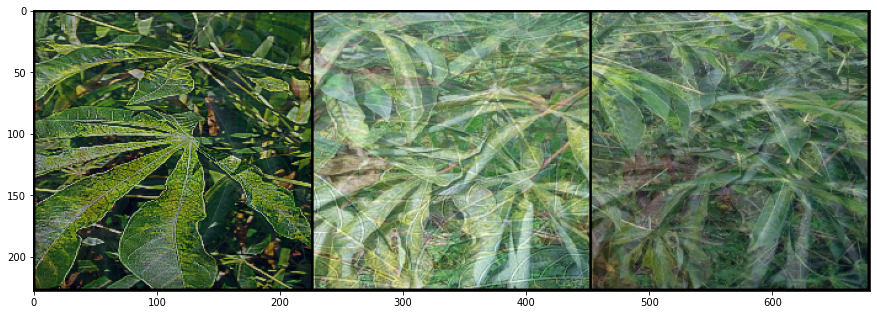

In [ ]:
lf = LabelSmoothingCrossEntropy()
mx = Mixup(0.5)

im = test_func(mx)
grid = make_grid(im[:3], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = mx.loss(lf, pred)

print(loss, mx.yb1, mx.yb2, mx.lam)

plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
#export
#modified from : https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
class Cutmix():
    "Implementation of `https://arxiv.org/abs/1905.04899`" 
    def __init__(self, alpha: float = 1.0):
        self.device = None
        self.distrib = alpha
    
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.device)
        
        # uniform
        cx = torch.randint(0, W, (1,), device=self.device)
        cy = torch.randint(0, H, (1,), device=self.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1.to(self.device), y1.to(self.device), x2.to(self.device), y2.to(self.device)
    
    def __call__(self, xb:torch.Tensor, yb:torch.Tensor, model:Module=None):
        bs, _, H, W = xb.size()
        
        if self.device is None: self.device = xb.device
        
        self.lam = np.random.beta(self.distrib, self.distrib)
        self.lam = torch.tensor(self.lam, device=self.device)
        
        index = torch.randperm(bs, device=self.device)
        
        self.yb1, self.yb2 = yb, yb[index]
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        xb[:, :, x1:x2, y1:y2] = xb[index, :, x1:x2, y1:y2]
        # adjust lambda to exactly match pixel ratio
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        return xb
        
    def loss(self, lf, pred, reduction='mean'):
        self.old_lf = lf
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred, self.yb2), lf(pred, self.yb1), self.lam)
        return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

tensor(1.4113) tensor([3, 3, 3, 3, 3, 1, 1, 3]) tensor([3, 1, 1, 3, 3, 3, 3, 3]) 0.6046715974807739


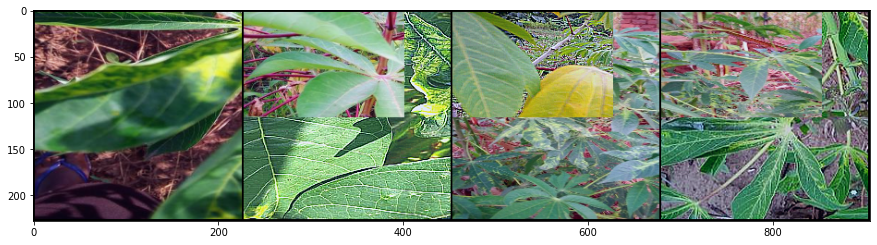

In [ ]:
cx = Cutmix()

im = test_func(cx)
grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = cx.loss(lf, pred)

print(loss, cx.yb1, cx.yb2, cx.lam)

plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
#export
# @TODO: add midlevel classification branch in learning.
class SnapMix():
    "Implementation of https://arxiv.org/abs/2012.04846"
    def __init__(self, alpha: float = 5.0, conf_prob: float = 1.0):
        self.device  = None
        self.distrib, self.conf_prob = alpha, conf_prob
        
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.device)
        
        #uniform
        cx = torch.randint(0, W, (1,), device=self.device)
        cy = torch.randint(0, H, (1,), device=self.device)

        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        
        return x1.to(self.device), y1.to(self.device), x2.to(self.device), y2.to(self.device)
      
        
    def get_spm(self, input: torch.Tensor, target: torch.Tensor, model: SnapMixTransferLearningModel):
        
        bs, _, H, W = input.size()
        img_size = (H, W)
        bs = input.size(0)
        
        with torch.no_grad():
            fms  = model.encoder(input)
            
            # grab the classification layer of the model
            clsw = model.fc
            
            weight = clsw.weight.data
            weight = weight.view(weight.size(0),weight.size(1),1,1)
            bias   = clsw.bias.data
            
            fms      = F.relu(fms)
            poolfea  = F.adaptive_avg_pool2d(fms,(1,1)).squeeze()
            clslogit = F.softmax(clsw.forward(poolfea))
            
            logitlist = []
            
            for i in range(bs):
                logitlist.append(clslogit[i,target[i]])
            
            clslogit = torch.stack(logitlist)
            
            out = F.conv2d(fms, weight, bias=bias)
        
            outmaps = []
            for i in range(bs):
                evimap = out[i,target[i]]
                outmaps.append(evimap)
            
            if img_size is not None:
                outmaps = torch.stack(outmaps)
                outmaps = outmaps.view(outmaps.size(0),1,outmaps.size(1),outmaps.size(2))
                outmaps = F.interpolate(outmaps, img_size, mode='bilinear', align_corners=False)
            
            outmaps = outmaps.squeeze()
        
            for i in range(bs):
                outmaps[i] -= outmaps[i].min()
                outmaps[i] /= outmaps[i].sum()
            
        return outmaps, clslogit
        
    def __call__(self, xb:torch.Tensor, yb:torch.Tensor, model: SnapMixTransferLearningModel):
        bs, _, H, W = xb.size()
        
        self.img_size = (H,W)
        
        if self.device is None: self.device = xb.device
            
        r = np.random.rand(1)
        
        lam_a = torch.ones(xb.size(0), device=self.device)
        lam_b = 1 - lam_a
        
        self.yb  = yb
        self.yb1 = yb.clone()
        
        rand_index = torch.randperm(bs, device=self.device)
        
        if r < self.conf_prob:
            wfmaps,_  = self.get_spm(xb, yb, model)
            
            lam = np.random.beta(self.distrib, self.distrib)
            lam = torch.tensor(lam, device=self.device)
            
            lam1 = np.random.beta(self.distrib, self.distrib)
            lam1 = torch.tensor(lam1, device=self.device)
            
            rand_index = torch.randperm(bs, device=self.device)
            
            wfmaps_b = wfmaps[rand_index,:,:]
            self.yb1 = self.yb[rand_index]
            
            same_label = self.yb == self.yb1
            
            bbx1, bby1, bbx2, bby2 = self.rand_bbox(W, H, lam)
            bbx1_1, bby1_1, bbx2_1, bby2_1 = self.rand_bbox(W, H, lam1)
            
            area  = (bby2-bby1)*(bbx2-bbx1)
            area1 = (bby2_1-bby1_1)*(bbx2_1-bbx1_1)
            
            if  area1 > 0 and  area>0:
                ncont = xb[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
                ncont = F.interpolate(ncont, size=(bbx2-bbx1,bby2-bby1), mode='bilinear', align_corners=True)
                xb[:, :, bbx1:bbx2, bby1:bby2] = ncont
                
                lam_a = 1 - wfmaps[:,bbx1:bbx2,bby1:bby2].sum(2).sum(1)/(wfmaps.sum(2).sum(1)+1e-8)
                lam_b = wfmaps_b[:,bbx1_1:bbx2_1,bby1_1:bby2_1].sum(2).sum(1)/(wfmaps_b.sum(2).sum(1)+1e-8)
                
                tmp = lam_a.clone()
                
                lam_a[same_label] += lam_b[same_label]
                lam_b[same_label] += tmp[same_label]
                
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (xb.size()[-1] * xb.size()[-2]))
                lam_a[torch.isnan(lam_a)] = lam
                lam_b[torch.isnan(lam_b)] = 1-lam
        
        self.yb1, self.yb2 = self.yb, self.yb1
        self.lam_a, self.lam_b = lam_a.to(self.device), lam_b.to(self.device)
        self.model, self.xb = model, xb
        return self.xb
        
    def loss(self, lf, pred, *args, **kwargs):
        loss_a = lf(pred, self.yb1)
        loss_b = lf(pred, self.yb2)
        loss   = torch.mean(loss_a * self.lam_a + loss_b * self.lam_b)
        return loss

tensor(2.5836) tensor([3, 3, 3, 2, 1, 3, 3, 3]) tensor([3, 2, 3, 3, 1, 3, 3, 3]) tensor([1.0965, 0.6739, 1.0223, 0.6429, 1.0819, 1.0691, 0.9823, 0.9772]) tensor([1.0965, 0.3281, 1.0223, 0.3018, 1.0819, 1.0691, 0.9823, 0.9772])


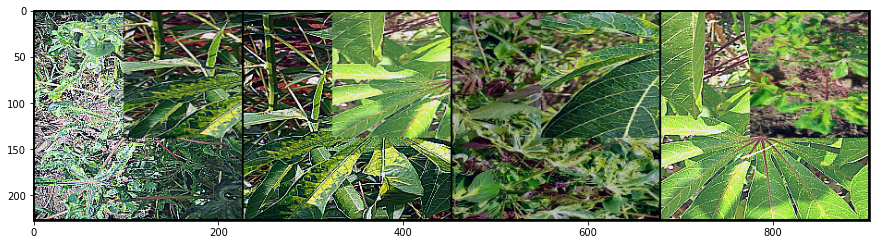

In [ ]:
import timm
encoder = timm.create_model('resnet18', pretrained=False)
model = SnapMixTransferLearningModel(encoder , c=len(idx2lbl), cut=-2, act=torch.nn.ReLU(inplace=True))

sx = SnapMix(alpha=5.0, conf_prob=1.0)

im = test_func(sx, model=model)
grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = sx.loss(lf, pred)

print(loss, sx.yb1, sx.yb2, sx.lam_a, sx.lam_b)

plt.figure(figsize=(15,15))
plt.imshow(grid)

tensor(3.4661) tensor([3, 3, 3, 2, 2, 1, 3, 3]) tensor([3, 3, 3, 1, 2, 2, 3, 3]) tensor([1.2664, 1.3086, 1.2810, 0.8458, 1.4275, 0.8410, 1.3361, 1.2490]) tensor([1.2664, 1.3086, 1.2810, 0.5936, 1.4275, 0.5589, 1.3361, 1.2490])


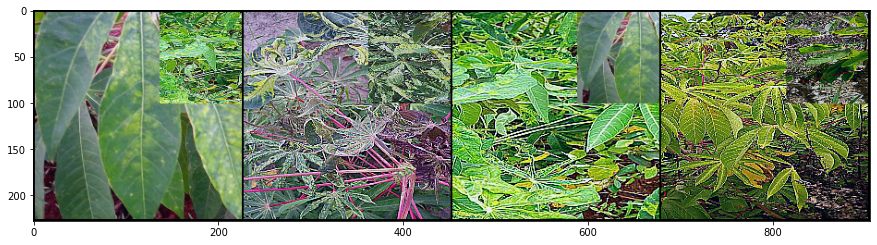

In [ ]:
encoder = timm.create_model('efficientnet_b3', pretrained=False)
model = SnapMixTransferLearningModel(encoder , c=len(idx2lbl), cut=-2, act=torch.nn.ReLU(inplace=True))

sx = SnapMix(alpha=5.0, conf_prob=1.0)

im = test_func(sx, model=model)
grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()

pred = F.one_hot(mx.yb1, len(idx2lbl)).float()
loss = sx.loss(lf, pred)

print(loss, sx.yb1, sx.yb2, sx.lam_a, sx.lam_b)

plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers_schedules.ipynb.
Converted 05_lightning.core.ipynb.
Converted 05a_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.
